In [1]:
# Base
import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import skimage.metrics
import torch
import torchinfo
import torchvision

%load_ext autoreload
%autoreload 2

#### Podatkovne zbirke

Število slik:          91
Interval širine slik:  [78, 508]
Interval višine slik:  [78, 387]
Povprečna širina slik: 264.12 +- 96.50
Povprečna višina slik: 203.58 +- 69.05


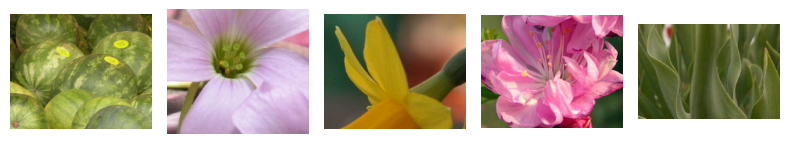

In [2]:
# T91
path = "datasets/T91/train/"

img_path_list = [os.path.join(path, name) for name in os.listdir(path)]

widths = []
heights = []
for img_path in img_path_list:
    with PIL.Image.open(img_path) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)

print(f"Število slik:          {len(img_path_list)}")
print(f"Interval širine slik:  [{np.min(widths)}, {np.max(widths)}]")
print(f"Interval višine slik:  [{np.min(heights)}, {np.max(heights)}]")
print(f"Povprečna širina slik: {np.mean(widths) :.2f} +- {np.std(widths) :.2f}")
print(f"Povprečna višina slik: {np.mean(heights) :.2f} +- {np.std(heights) :.2f}")

indices = np.random.default_rng().choice(len(img_path_list), 5, replace=False)

_, axes = plt.subplots(1, 5, figsize=(8, 3), squeeze=False)
for c in range(axes.shape[1]):
    img_path = img_path_list[indices[c]]
    with PIL.Image.open(img_path) as img:
        axes[0, c].imshow(img)
        axes[0, c].axis("off")
            
plt.tight_layout()

#### Učna in validacijska množica

In [3]:
from torch.utils import data

# Generator in nalaganje podatkovnih zbirk
from dataset import data_generator, load_dateset

# Argumenti
patch_size = 33
batch_size = 32
scale_factor = 2
extension = 11

# Učna podatkovna zbirka
train_dataset_org, train_dataset_lr = load_dateset("datasets/T91/train/", scale_factor, extension)

train_dataset = data_generator(train_dataset_org, train_dataset_lr, patch_size)
train_data_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# Validacijska podatkovna zbirka
val_dataset_org, val_dataset_lr = load_dateset("datasets/T91/train/", scale_factor, extension)

val_dataset = data_generator(val_dataset_org, val_dataset_lr, 0)
val_data_loader = data.DataLoader(val_dataset, batch_size=1, pin_memory=True)

#### Testiranje generiranja

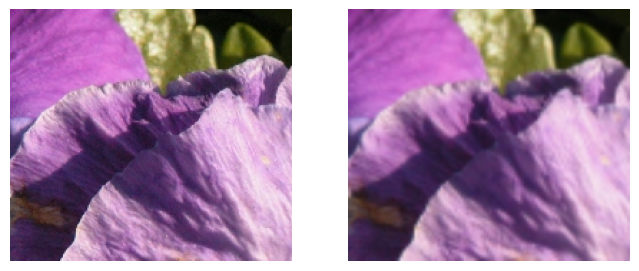

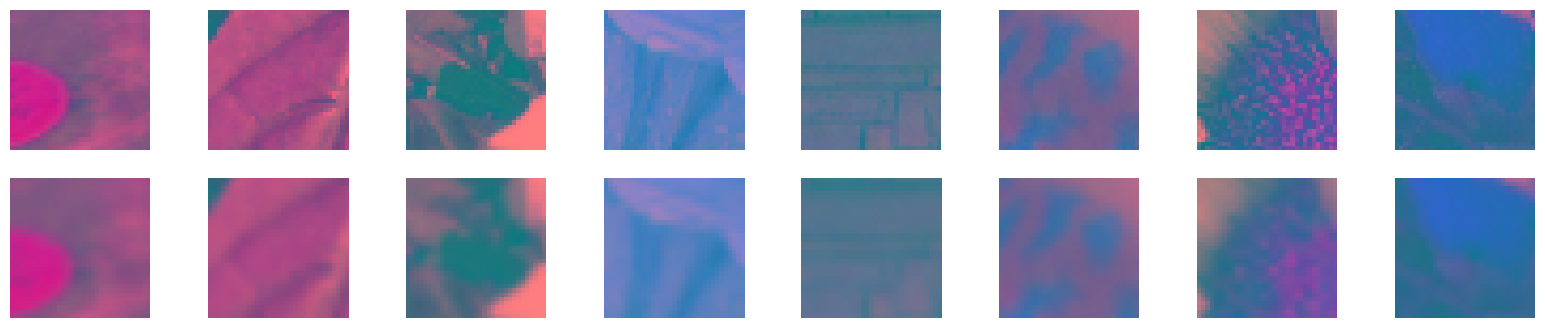

In [16]:
from helper import convert_ycbcr_to_rgb

# Učna podatkovna zbirka
_, axes = plt.subplots(1, 2, figsize=(8, 5))
for i in range(0, batch_size):
    # Izris - high-res
    axes[0].imshow(convert_ycbcr_to_rgb(train_dataset_org[0]))
    axes[0].axis("off")

    # Izris - low-res
    axes[1].imshow(convert_ycbcr_to_rgb(train_dataset_lr[0]))
    axes[1].axis("off")

# Klic ene iteracije generatorja
batch_hr, batch_lr = next(iter(train_data_loader))

_, axes = plt.subplots(2, 8, figsize=(20, 4))
for i in range(0, 8):
    # Izris podslike - high-res
    axes[0, i].imshow(torch.moveaxis(batch_hr[i], 0, 2))
    axes[0, i].axis("off")

    # Izris podslike - low-res
    axes[1, i].imshow(torch.moveaxis(batch_lr[i], 0, 2))
    axes[1, i].axis("off")

#### Nevronska mreža

In [5]:
# Nevronska mreža
from neural_network import *

In [30]:
# Model
model = SuperResConvNeuralNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.MSELoss()
model_file_name = f"model_x{scale_factor}.pt"

print(torchinfo.summary(model, [1, 1, 33, 33]))

Layer (type:depth-idx)                   Output Shape              Param #
SuperResConvNeuralNet                    [1, 1, 33, 33]            --
├─Conv2d: 1-1                            [1, 64, 33, 33]           5,248
├─ReLU: 1-2                              [1, 64, 33, 33]           --
├─Conv2d: 1-3                            [1, 32, 33, 33]           51,232
├─ReLU: 1-4                              [1, 32, 33, 33]           --
├─Conv2d: 1-5                            [1, 1, 33, 33]            801
Total params: 57,281
Trainable params: 57,281
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 62.38
Input size (MB): 0.00
Forward/backward pass size (MB): 0.85
Params size (MB): 0.23
Estimated Total Size (MB): 1.08


In [ ]:
# Učenje
epochs = 100

# Beleženje zgodovine
history = {"train_loss": [], "val_loss": []}

model.to(device)
nn_train(model, train_data_loader, val_data_loader, epochs, optimizer, loss_fn, history)

# Shranjevanje modela
torch.save(model, model_file_name)

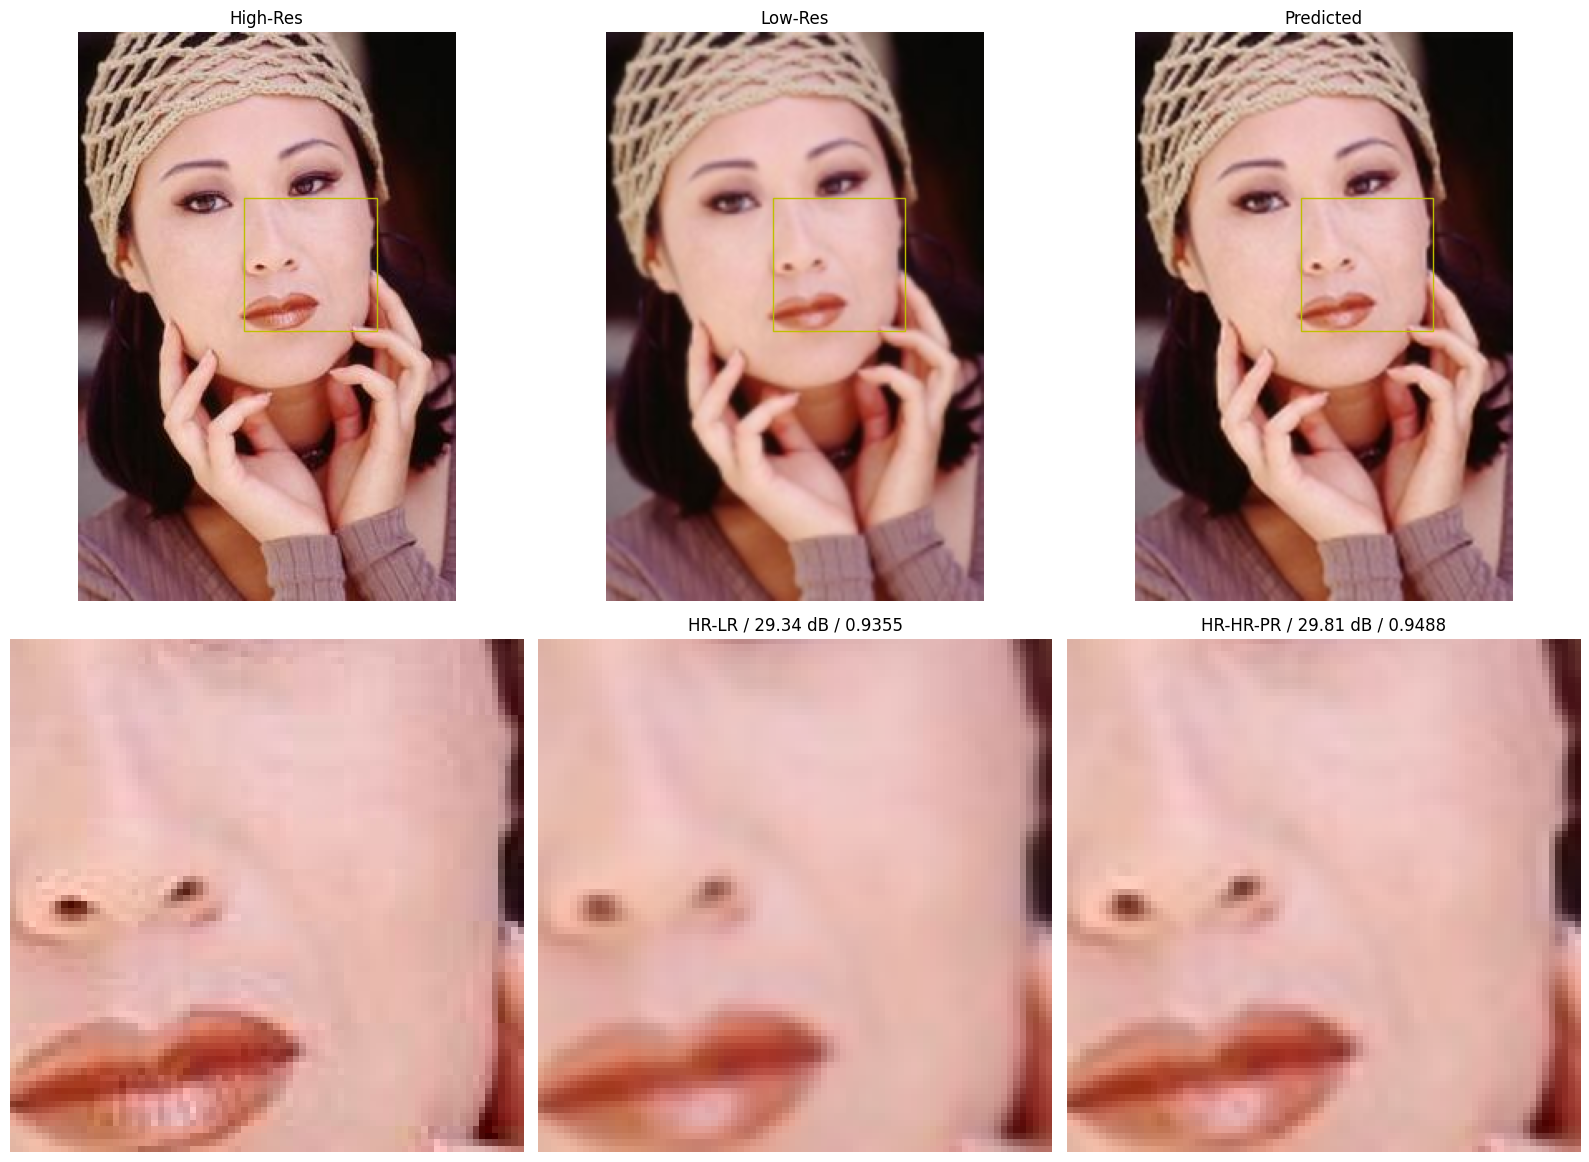

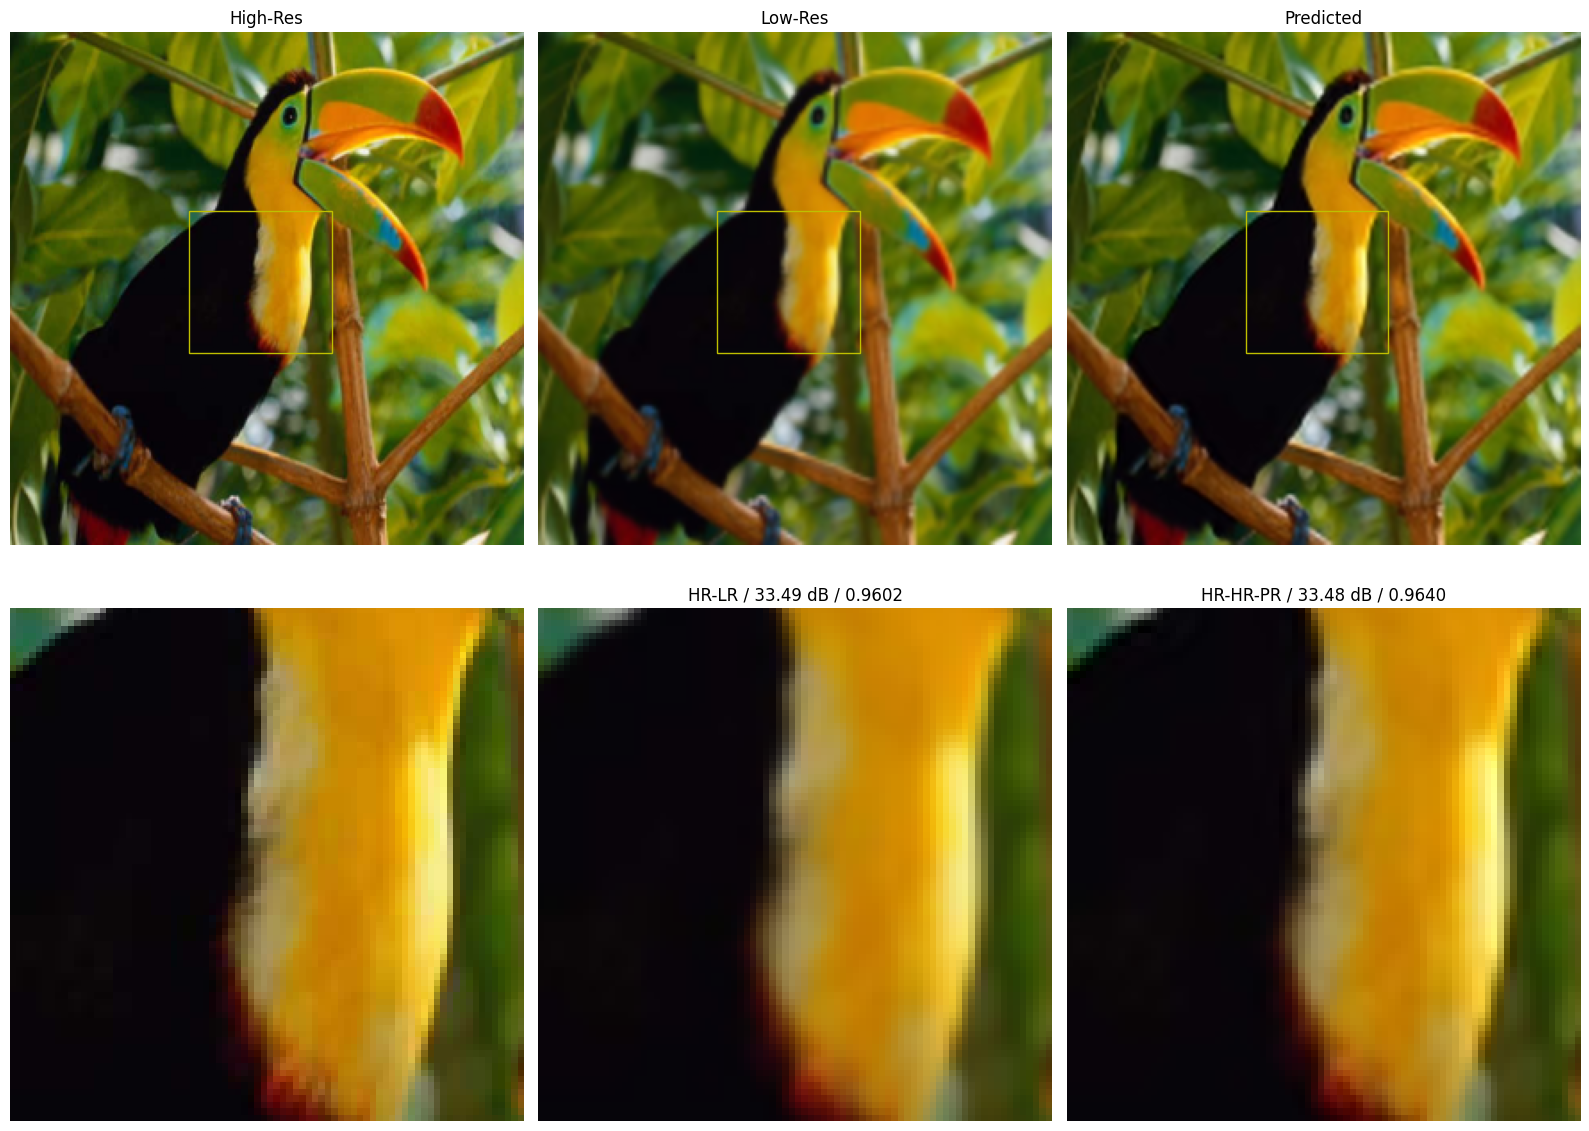

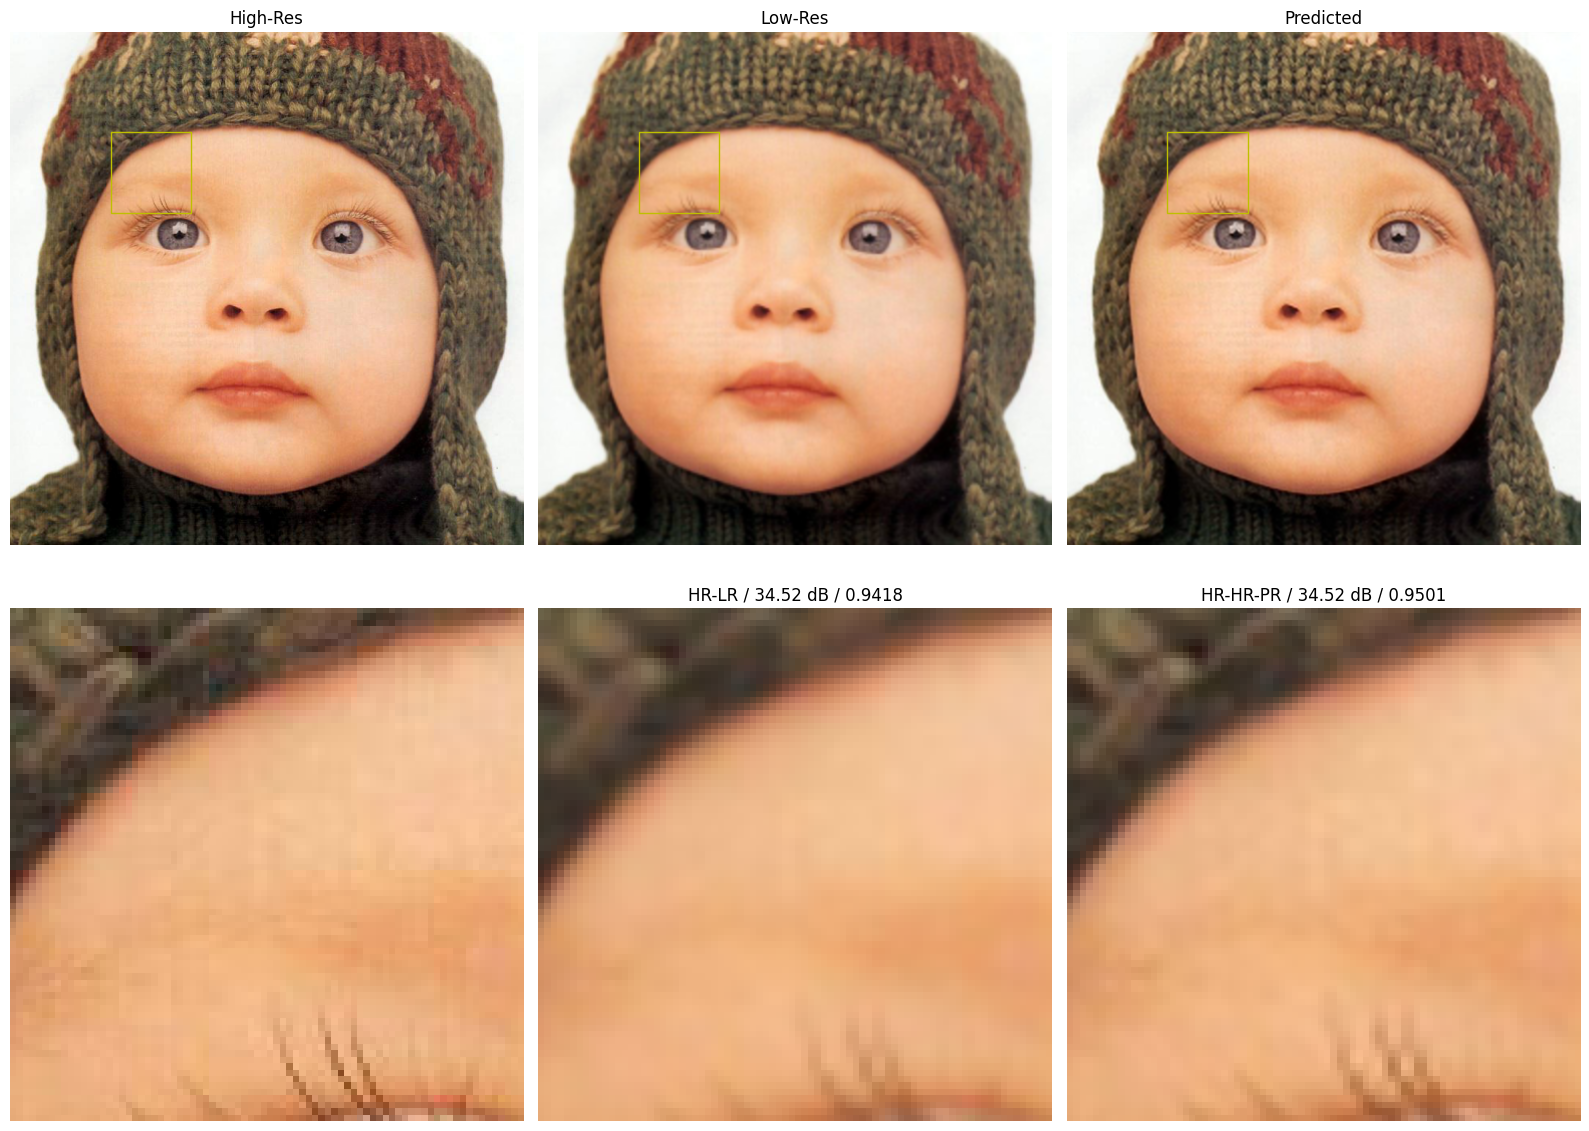

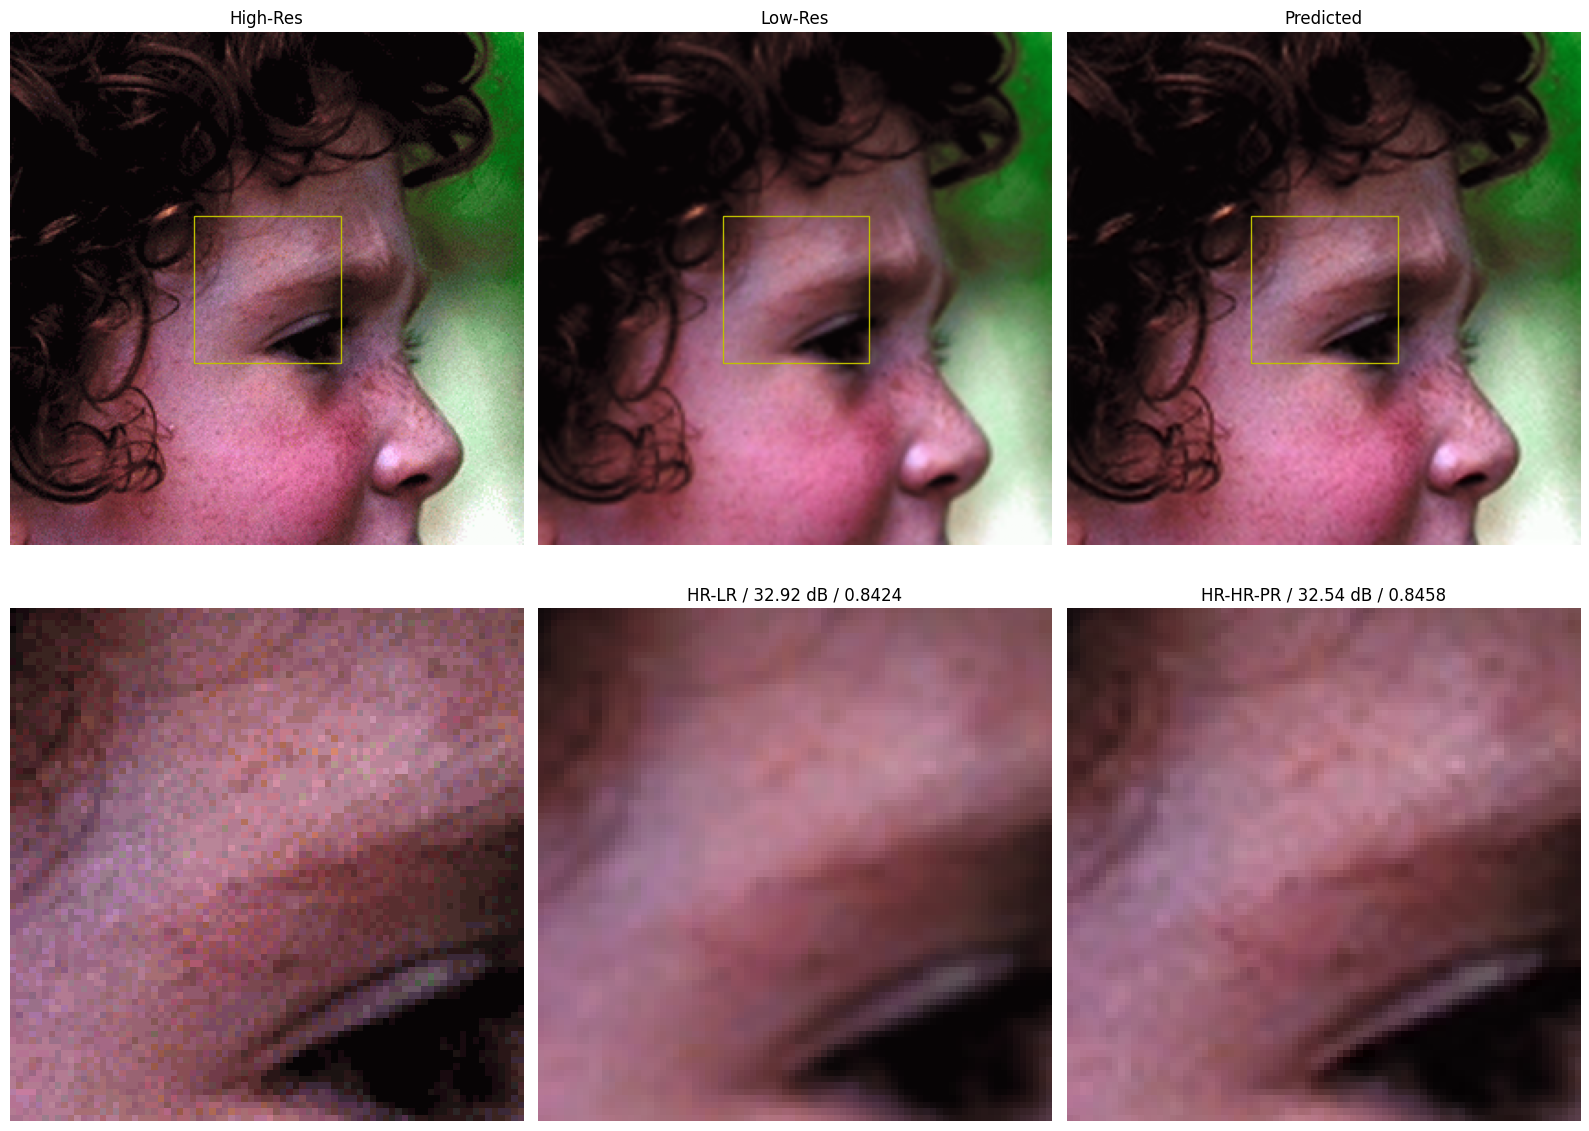

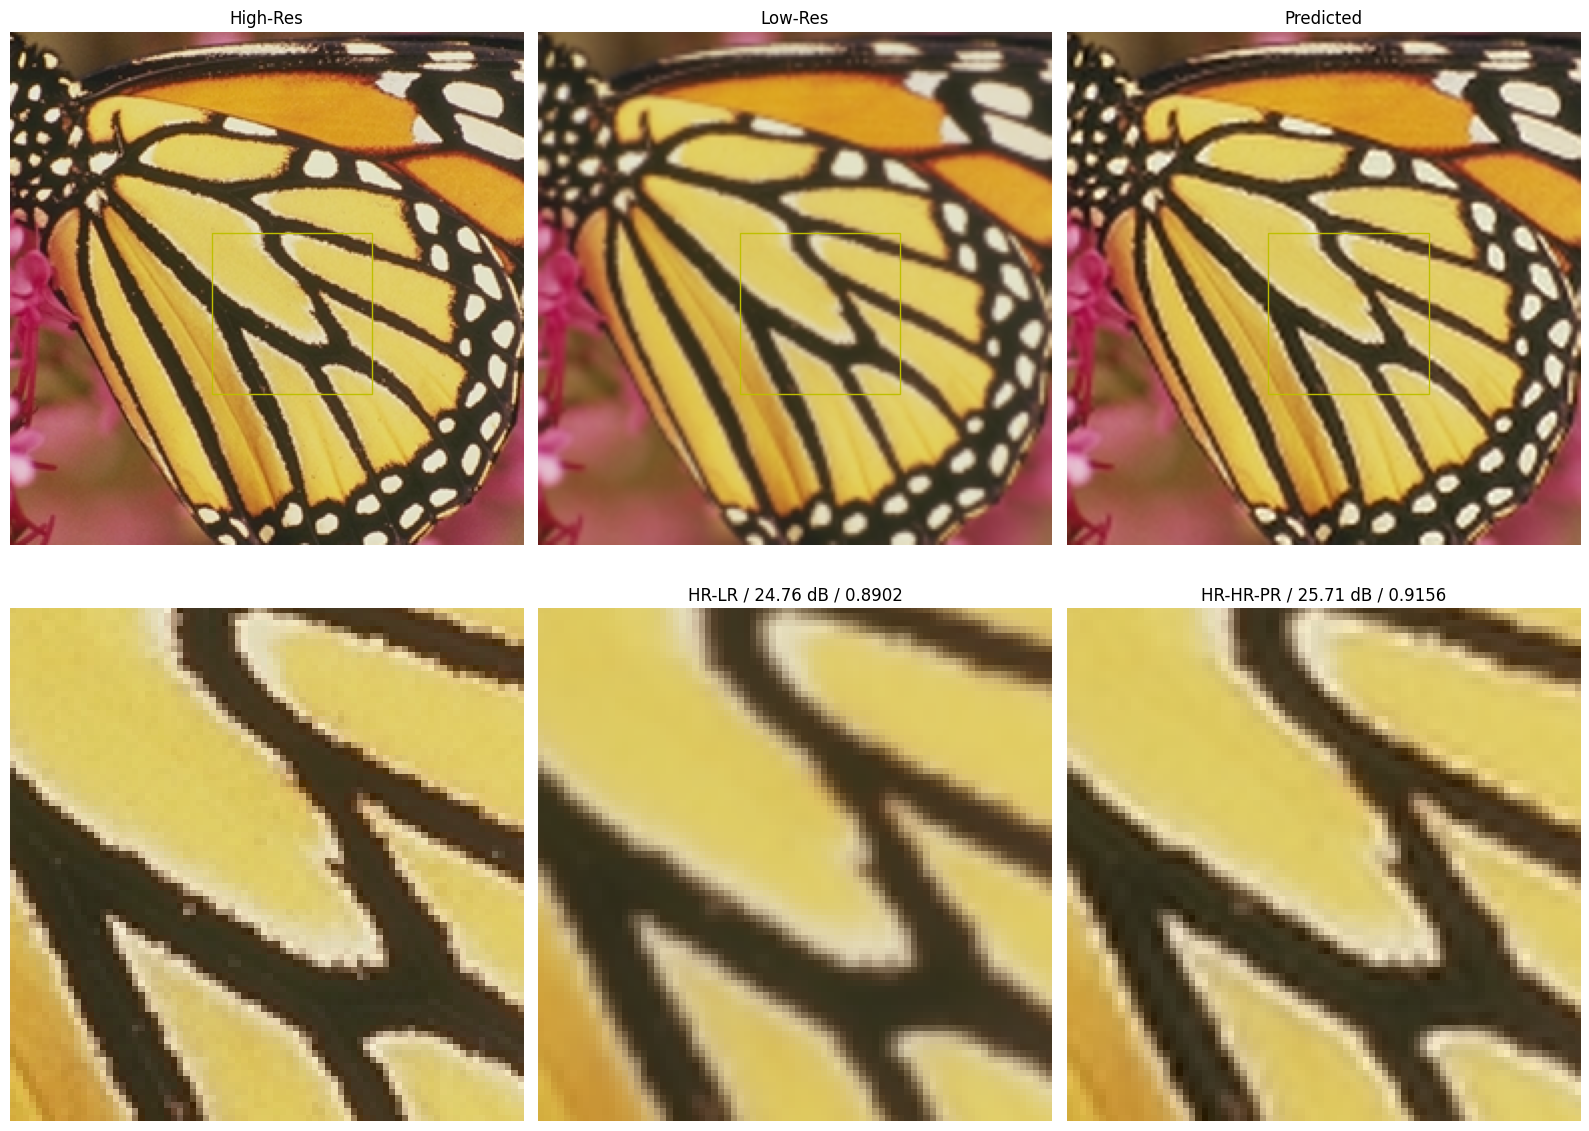

In [38]:
import random

# Pretvorba iz RGB v YCbCr
from helper import convert_rgb_to_ycbcr
# Pretvorba originalne slike v low-res sliko
from helper import transform_org_to_lr
# Nalaganje slike
from helper import load_image_to_tensor

# Testiranje naučenega modela
model = torch.load(model_file_name, weights_only=False)
model.to(device)
model.eval()

# Testne slike
test_path = "datasets/Set5/test/"
test_path_list = [os.path.join(test_path, name) for name in os.listdir(test_path)]

with torch.no_grad():
    for img_path in random.sample(test_path_list, 5):

        # Nalaganje slike
        img_hr = load_image_to_tensor(img_path)

        # Skaliranje
        img_lr = transform_org_to_lr(img_hr, scale_factor)

        # Pretvorba v YCbCr
        img_lr_ycbcr = convert_rgb_to_ycbcr(img_lr)
        img_hr_ycbcr = convert_rgb_to_ycbcr(img_hr)

        # Izločitev Y kanala
        # [3, H, W] -> [1, H, W]
        img_lr_y = img_lr_ycbcr[0:1]
        img_hr_y = img_hr_ycbcr[0:1]

        # Dodajanje osi
        # [1, H, W] -> [1, 1, H, W]
        img_lr_y = img_lr_y[np.newaxis]

        # Filtriranje z NM
        img_hr_y_pred = model(img_lr_y.to(device)).detach().to('cpu')[0]

        # Omejive na ustrezen interval
        img_hr_y_pred = img_hr_y_pred.clamp(0, 1)

        # Dodajanje kanalov CbCr in pretvorba v RGB
        img_hr_pred_rgb = convert_ycbcr_to_rgb(torch.concat([img_hr_y_pred, img_lr_ycbcr[1:3]]))

        # [H, W]
        img_hr_y_pred = img_hr_y_pred.squeeze().numpy()
        # [H, W]
        img_lr_y = img_lr_y.squeeze().numpy()
        # [H, W]
        img_hr_y = img_hr_y.squeeze().numpy()

        # Metrike

        # PSNR med High-Res (izvorno) in Low-Res 
        prsn_hr_lr = skimage.metrics.peak_signal_noise_ratio(img_hr_y, img_lr_y)

        # PSNR med High-Res (izvorno) in Predicted 
        prsn_hr_hr_pred = skimage.metrics.peak_signal_noise_ratio(img_hr_y, img_hr_y_pred)

        # SSIM med High-Res (izvorno) in Low-Res
        ssim_hr_lr = skimage.metrics.structural_similarity(img_hr_y, img_lr_y, data_range=1)

        # SSIM med High-Res (izvorno) in Predicted 
        ssim_hr_hr_pred = skimage.metrics.structural_similarity(img_hr_y, img_hr_y_pred, data_range=1)

        # Plot
        _, axes = plt.subplots(2, 3, figsize=(16, 12))

        # Premik dimenzije s barvnimi kanali na konec
        img_hr = img_hr.permute(1, 2, 0)
        img_lr = img_lr.permute(1, 2, 0)

        # Velikost območja in območje povečave
        zoom_position = (100, 100)
        zoom_size = 80

        axes[0, 0].imshow(img_hr)
        axes[0, 0].add_patch(patches.Rectangle(zoom_position, zoom_size, zoom_size, edgecolor="y", facecolor="none"))
        axes[0, 0].axis("off")
        axes[0, 0].set_title("High-Res")
        
        axes[0, 1].imshow(img_lr)
        axes[0, 1].add_patch(patches.Rectangle(zoom_position, zoom_size, zoom_size, edgecolor="y", facecolor="none"))
        axes[0, 1].axis("off")
        axes[0, 1].set_title("Low-Res")
        
        axes[0, 2].imshow(img_hr_pred_rgb)
        axes[0, 2].add_patch(patches.Rectangle(zoom_position, zoom_size, zoom_size, edgecolor="y", facecolor="none"))
        axes[0, 2].axis("off")
        axes[0, 2].set_title("Predicted")

        axes[1, 0].imshow(img_hr[zoom_position[1]:zoom_position[1]+zoom_size, zoom_position[0]:zoom_position[0]+zoom_size])
        axes[1, 0].axis("off")
        
        axes[1, 1].imshow(img_lr[zoom_position[1]:zoom_position[1]+zoom_size, zoom_position[0]:zoom_position[0]+zoom_size])
        axes[1, 1].set_title(f"HR-LR / {prsn_hr_lr :.2f} dB / {ssim_hr_lr :.4f}")
        axes[1, 1].axis("off")
        
        axes[1, 2].imshow(img_hr_pred_rgb[zoom_position[1]:zoom_position[1]+zoom_size, zoom_position[0]:zoom_position[0]+zoom_size])
        axes[1, 2].set_title(f"HR-[HR-PR] / {prsn_hr_hr_pred :.2f} dB / {ssim_hr_hr_pred :.4f}")
        axes[1, 2].axis("off")
        
        plt.tight_layout()


#### Primer poročanja rezultatov - potrebno ločeno za vsak faktor povečave

PSNR - Peak signal-to-noise ratio  
SSIM - Structural similarity index measure  
hr - Originalna High-Res slika  
lr - Slika nizke resolucije  
hr-pred - Slika visoke resolucije (predikcija) - izhod NM

Podatkovna zbirka Set5:
```
PSNR (hr, lr):      xx.yy +- xx.yy dB
PSNR (hr, hr-pred): xx.yy +- xx.yy dB
SSIM (hr, lr):      x.yyy +- x.yyy
SSIM (hr, hr-pred): x.yyy +- x.yyy
```

Podatkovna zbirka Set14:
```
PSNR (hr, lr):      xx.yy +- xx.yy dB
PSNR (hr, hr-pred): xx.yy +- xx.yy dB
SSIM (hr, lr):      x.yyy +- x.yyy
SSIM (hr, hr-pred): x.yyy +- x.yyy
```